# Generating Synthetic Stellar Catalogues of Spiral Galaxies
### Sam Kirkwood, UNSW Physics 2021

#### What is this project about?
Thanks to the many surveys conducted over the past few decades, we have detailed observational data of many of the Milky Way’s stars, and this has allowed us to build a fairly good picture of what our own galaxy looks like. However, some elements of the Milky Way’s structure and history remain unknown - in part due to limitations on observations, but also because the Milky Way is the only galaxy we can see at this level of detail. Without other, similar spiral galaxies to compare to, it is difficult to determine which features of the Milky Way have influenced its formation history to lead to the state we observe it in today. A library of similar spiral galaxies would improve the capacity of galactic archaeologists to make inferences about how structure
and evolution interact, which would inform about galactic evolutionary processes in general. 

The primary aim of this project is to translate spectroscopic data from nearby spiral galaxies into a 3D synthetic stellar catalogue of the galaxy. Though other groups have produced similar synthetic surveys, they are often based on simulated data.

#### Data sources
The primary goal of this project is to build a process that can be utilised to create stellar catalogues for a number of spiral galaxies. However, for testing and analysis, we looked at three specific galaxies from the Sydney-Australian-Astronomical-Observatory Multi-object Integral-Field Spectrograph (SAMI) survey. The three galaxies have CATIDs 106717, 240108, and 9403800352; and will hereafter be referred to as Galaxy 1, Galaxy 2, and Galaxy 3 respectively.

The SAMI survey divides spectroscopic data into two cubes, a blue and a red cube. Each data cube comprises 2048 spectral slices of a 50x50 grid of spatial pixels (spaxels). The blue cube is measured over the wavelength range 3650 to 5800 Å and a red cube over the range 6240 to 7460 Å. The data release contains three pre-binned cubes - referred to as ‘adaptive’, ‘annular’ and ‘sectors’. For this project, we use the ‘adaptive’ cube, where adjacent spaxels have been binned to produce a constant signal to noise ratio (SNR) of 20 per bin using the Voronoi binning method (Cappellari & Copin, 2003).

### Contents
[Step 1: generate the CMD (colour-magnitude diagram) files](#Step_1)

[Step 2: download the files](#Step_2)

[Step 3: add a column for flix values](#Step_3)

[Step 4: use 'Pyphot' package to find flux in g-band](#Step_4)

[Step 5: assign positions to stars](#Step_5)

[Step 6a: generate whole galaxy overview](#Step_6a)

[Step 6b: generate line of sight catalogue](#Step_6b)

[Miscellaneous](#Misc)

In [ ]:
# import packages and load files

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from urllib.parse import urljoin
import time
from datetime import datetime
from pytz import timezone
import os
import pandas as pd
import pyphot
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS

In [42]:
lw1 = np.load('data/106717_SPV/results_no_regul/106717/voronoi/106717_voronoi_weights_LW.npy')
lw2 = np.load('data/240108_SPV/results_no_regul/240108/voronoi/240108_voronoi_weights_LW.npy')
lw3 = np.load('data/9403800352_SPV/results_no_regul/9403800352/voronoi/9403800352_voronoi_weights_LW.npy')

In [5]:
print(lw1.shape, lw2.shape, lw3.shape)
galaxies = [lw1, lw2, lw3]

(329, 15, 8, 2) (187, 15, 8, 2) (184, 15, 8, 2)


In [6]:
# list all the params
alphas = ["P00","P04"]
grids = ["P00O1D1E1Y247", "P04O1D1E1Y247"]
ages = ["14000","11000","9000","7000","4000","2000","1000","800","500","400","300","200","100","60","30"]
metallicities = ["-1.49","-0.96","-0.66","-0.35","-0.25","0.06","0.26","0.4"]

<a id='Step 1'></a>
# Step 1: generate the CMD files

### Find number of significant templates


In [24]:
sigs = np.zeros((15,8,2))
for galaxy in galaxies:
    for bn in range(galaxy.shape[0]):
        sigs += galaxy[bn,:,:,:] > 0.01

print("Sig templates: " + str(len(sigs[sigs>0])) + " templates out of 240")

Sig templates: 204 templates out of 240


In [25]:
non_sig = np.where(sigs == 0)

### Generate CMD files

In [3]:
session = HTMLSession()

def get_all_forms(url):
    """Returns all form tags found on a web page's `url` """
    # GET request
    res = session.get(url)
    # for javascript driven website
    # res.html.render()
    soup = BeautifulSoup(res.html.html, "html.parser")
    return soup.find("form")


def get_form_details(form):
    """Returns the HTML details of a form,
    including action, method and list of form controls (inputs, etc)"""
    details = {}
    # get the form action (requested URL)
    action = form.attrs.get("action").lower()
    # get the form method (POST, GET, DELETE, etc)
    # if not specified, GET is the default in HTML
    method = form.attrs.get("method", "get").lower()
    
    # get all form inputs
    inputs = []
    for input_tag in form.find_all("input"):
        # get type of input form control
        input_type = input_tag.attrs.get("type", "text")
        # get name attribute
        input_name = input_tag.attrs.get("name")
        # get the default value of that input tag
        input_value =input_tag.attrs.get("value", "")
        # add everything to that list
        inputs.append({"type": input_type, "name": input_name, "value": input_value})
    
    # get all select boxes
    selects = []
    for select_tag in form.find_all("select"):
        # get type of input form control
        select_id = select_tag.attrs.get("id")
        # get name attribute
        select_name = select_tag.attrs.get("name")
        inputs.append({"type": "select", "id": select_id, "name": select_name})
    
    # put everything to the resulting dictionary
    details["action"] = action
    details["method"] = method
    details["inputs"] = inputs
    return details

url = "http://basti-iac.oa-teramo.inaf.it/syncmd.html"
# get all form tags
form = get_all_forms(url)
form_details = get_form_details(form)

In [198]:
# the data body we want to submit
# --------
#     alpha >> P00
#              P04
# --------
#     grid >> alpha=0   P00O1D1E1Y247
#             alpha=0   P00O1D0E1Y247 no diffusion
#             alpha=0.4 P04O1D1E1Y247
# --------
#     sfh_age >> age1 age2 age3
#     sfh_sfr >> age1 age2 age3
# --------
#     sfh_amr >> metallicity
# --------
#     nstar >> 1000
# --------
#     indimf >> 1
#            >> 0%2C+-2.35 ??
# --------

for index, met in enumerate(metallicities):
    for alpha, grid in zip(alphas, grids):
        
        # first check if we can skip any
        temp_ages = ages.copy()
        for where, m in enumerate(non_sig[1]):
            if index == m:
                if (non_sig[2][where] == 0 and alpha == "P00") or (non_sig[2][where] == 1 and alpha == "P04"):
                    age_to_remove = ages[non_sig[0][where]]
                    if age_to_remove in temp_ages:
                        temp_ages.remove(age_to_remove)
                        
        # make the list entries - 4 of them
        age_list = " ".join(np.repeat(temp_ages,2))
        formation_rates = " ".join(np.tile(["1.0","0.0"],len(temp_ages)))
        met_list = " ".join(np.repeat(met,2*len(temp_ages)))
        var_list = " ".join(np.repeat("0.0",2*len(temp_ages)))
        
        # check if alpha=0 and Fe/H=0.4 --> use  different grid
        final_grid = "P00O1D0E1Y247" if (alpha == "P00" and met == "0.4") else grid
        
        data = {'id_scmd': 'sKKw2403%',
                'alpha': alpha,
                'grid': final_grid,
                'sfh_age': age_list, # list
                'sigma': '0.0',
                'sfh_sfr': formation_rates, # list
                'igma': '0',
                'sfh_amr': met_list, # list
                'sfh_sig': var_list, # list
                'nstar': '10000',
                'minf2': '0.1',
                'fracb': '0.0',
                'qfact': '0.7',
                'indimf': '0, -2.35',
                'indceph': '0',
                'iseed1': '158963327',
                'iseed2': '341964078',
                'bcsel': 'Sloan'}

        
        # Get current time so I can find the files later
        format = "%Y-%m-%d-%H-%M-%S"

        # Current time in UTC
        now_utc = datetime.now(timezone('UTC'))

        # Convert to Europe/Rome time zone
        now_rome = now_utc.astimezone(timezone('Europe/Rome'))
        
        # submit data
        url = urljoin(url, form_details["action"])
        res = session.get(url, params=data)

        # update time
        now_rome += res.elapsed
        
        # log result
        outcome = "Fail"
        if "ready to be processed" in str(res.content): outcome = "Success"
            
        f = open("power_IMF.txt", "a")
        f.write(now_rome.strftime(format) + "," + met + "," + alpha + "," + " ".join(temp_ages) + "," + outcome + "\n")
        f.close()
        
        time.sleep(3)
        
    print("finished metallicity = " + met)

finished metallicity = -1.49
finished metallicity = -0.96
finished metallicity = -0.66
finished metallicity = -0.35
finished metallicity = -0.25
finished metallicity = 0.06
finished metallicity = 0.26
finished metallicity = 0.4


<a id='Step 2'></a>
# Step 2: Download the files

In [7]:
url_base = "http://basti-iac.oa-teramo.inaf.it/SCMDOUT/s.kirkwood@student.unsw.edu.au%25"
filename = "power_IMF.txt"
os.mkdir(filename[0:-4])

f = open(filename, "r")
lines = f.readlines()
for num, line in enumerate(lines):
    timestamp = line.split(",")[0]
    new_url = url_base + timestamp + "_hdr"
    
    res = session.get(new_url)
    
    # sometimes need to subtract a second from the timestamp
    if not res.ok:
        ts_split = timestamp.split("-")
        ts_split[-1] = str(int(ts_split[-1]) - 1)
        if len(ts_split[-1]) is 1: ts_split[-1] = "0" + ts_split[-1] # zero pad if one digit
        new_timestamp = "-".join(ts_split)
        new_new_url = url_base + new_timestamp + "_hdr"
        
        res = session.get(new_new_url)
        if not res.ok: print("Couldn't find url: " + new_url)
            
    # for each file, save as e.g. P00_-1.49.txt     
    if res.ok:
        data_file = alphas[num % 2] + "_" + metallicities[int(np.floor(num / 2))] + ".txt"
        out = open(filename[0:-4] + "/" + data_file, "w")
        out.write(res.text)
        out.close()
            
f.close()

Couldn't find url: http://basti-iac.oa-teramo.inaf.it/SCMDOUT/s.kirkwood@student.unsw.edu.au%252021-10-09-09-56-05_hdr
Couldn't find url: http://basti-iac.oa-teramo.inaf.it/SCMDOUT/s.kirkwood@student.unsw.edu.au%252021-10-09-09-56-14_hdr


<a id='Step 3'></a>
# Step 3: Add column for flux

In [9]:
redshifts = [0.02564, 0.00652, 0.02789]
H0 = 70            # km s-1 Mpc-1
c = 299792         # km s-1
fz = 4.669e-9      # erg cm-2 s-1 A-1

def Mg_to_f(Mg, z):
    d = (c * z)/H0
    print("d: " + str(d) + "Mpc")
    mg = Mg - 5 + 5*np.log10(d*(1e6))
    return fz * 10**(-mg / 2.5)

In [10]:
dirname = "CMD-data/power_IMF/"
col_names = ["star-no", "logt", "Fe/H", "m", "logL", "logTeff", "initm", "index", "logP", "u", "g", "r", "i", "z"]
for filename in os.listdir(dirname):
    data = pd.read_csv(dirname+"/"+filename, sep="\s+", comment="#", header=None, names=col_names, engine='python')
    data = data.drop(["star-no", "initm", "index", "logP", "u", "r", "i", "z"], axis="columns")
    for redshift in redshifts:
        data[f"f_at_z_{redshift}"] = Mg_to_f(data["g"], redshift)
    data.to_csv(dirname+filename, index=False, sep=" ")
    print(filename)

P00_-0.25.txt
P00_-0.35.txt
P00_-0.66.txt
P00_-0.96.txt
P00_-1.49.txt
P00_0.06.txt
P00_0.26.txt
P00_0.4.txt
P04_-0.25.txt
P04_-0.35.txt
P04_-0.66.txt
P04_-0.96.txt
P04_-1.49.txt
P04_0.06.txt


<a id='Step 4'></a>
# Step 4: Pyphot
Run first cell for galaxy 1 OR second cell for galaxy 2 OR third cell for galaxy 3

In [371]:
gal1 = get_pkg_data_filename('sv-files/106717_blue_red_11_Y14SAR3_P004_15T079_2014_04_24-2014_05_04.fits')
binned_flux_adaptive = fits.getdata(gal1, ext=18)
binned_flux_adaptive = np.flip(binned_flux_adaptive, 2)
shape = binned_flux_adaptive.shape

mask = fits.getdata(gal1, ext=17)
mask = np.flip(mask, 1)

In [279]:
gal1 = get_pkg_data_filename('sv-files/240108_blue_red_7_Y15SAR4_P004_15T113_2016_03_03-2016_03_13.fits')
binned_flux_adaptive = fits.getdata(gal1, ext=18)
binned_flux_adaptive = np.flip(binned_flux_adaptive, 2)
shape = binned_flux_adaptive.shape

mask = fits.getdata(gal1, ext=17)
mask = np.flip(mask, 1)

In [345]:
gal1 = get_pkg_data_filename('sv-files/9403800352_blue_red_7_Y13SBR2_P005_A4038T003_2013_10_02-2013_10_08.fits')
binned_flux_adaptive = fits.getdata(gal1, ext=18)
binned_flux_adaptive = np.flip(binned_flux_adaptive, 2)
shape = binned_flux_adaptive.shape

mask = fits.getdata(gal1, ext=17)
mask = np.flip(mask, 1)

In [316]:
# get the header so we can grab the wavelength details
open_file = fits.open(gal1)
naxis, crpix, cdelt, crval, slice_size = open_file[0].header["NAXIS3"], open_file[0].header["CRPIX3"], \
                                         open_file[0].header["CDELT3"], open_file[0].header["CRVAL3"], \
                                         open_file[0].header["NAXIS1"]
open_file.close()

# make array of wavelengths
min_wav = crval-(crpix-1)*cdelt
max_wav = crval + (naxis-crpix)*cdelt
wavelengths = np.linspace(min_wav, max_wav, naxis)

# prepare data to use with the pyphot filter
blue_cube = binned_flux_adaptive[100:1850,:,:]*(10**(-16)) # selected blue cube to get rid of pesky NANs
fluxes = []
for bin_number in range(1, len(np.unique(mask))): # skip bin zero since it denotes the NANs
    
    # each bin has identical spectra, so we only want to grab one spectrum from each bin
    # we'll get the first spectrum from each bin that has no NANs in it
    # sometimes there are random NANs in the middle idk why
    locs = np.where(mask == bin_number)
    number_spaxels_in_bin = locs[0].shape[0]
    found = False
    
    for spx in range(number_spaxels_in_bin):
        if np.count_nonzero(np.isnan(blue_cube[:, locs[0][spx], locs[1][spx]])) == 0:
            fluxes.append(blue_cube[:, locs[0][spx], locs[1][spx]])
            found = True
            break
            
    # if no other spectra to use, fill in the NANs with the mean of neighbouring values
    if not found:
        row = locs[0][0]
        col = locs[1][0]
        for nan in np.where(np.isnan(blue_cube[:, row, col]) == True)[0]:
        
            # find next lowest value that isn't a NAN
            curr = blue_cube[nan, row, col]
            x = nan
            while(np.isnan(curr)):
                curr = blue_cube[x, row, col]
                x -= 1
            low = x + 1

            # find next highest value that isn't a NAN
            curr = blue_cube[nan, row, col]
            x = nan
            while(np.isnan(curr)):
                curr = blue_cube[x, row, col]
                x += 1
            high = x - 1

            blue_cube[nan, row, col] = np.mean([blue_cube[low, row, col], blue_cube[high, row, col]])
        fluxes.append(blue_cube[:, row, col])

# turn into an array to pass into the SEDs function
fluxes_array = np.array(fluxes)

# using SDSS g-band filter, need to use reinterp to get the wavelength range to match
# extractSEDs used instead of getFlux since it is faster when applying to many spectra
lib = pyphot.get_library()
f = lib['SDSS_g'].reinterp(wavelengths[100:1850]*pyphot.unit['angstrom'])

cls, seds = pyphot.extractSEDs(wavelengths[100:1850], fluxes_array, [f], absFlux=False)

Photometry:|##########| 1/1 100% [time: 00:00, eta: 00:00, 171.48 iters/sec]   


In [317]:
# output to a text file like so:
# spaxel row | spaxel column | belongs to bin # | total flux

spaxels = np.array(np.where(mask != 0))
spaxel_belongs_to_bin = np.array([mask[r][c] for r,c in spaxels.T])
flux_per_spaxel = np.array([seds[int(bin_no - 1)] for bin_no in spaxel_belongs_to_bin]) / 1e6 # for testing

stacked = np.vstack((spaxels, spaxel_belongs_to_bin.T, flux_per_spaxel.T))

out = open("flux_per_spaxel_reduced3.txt", "w")
np.savetxt(out, stacked.T, delimiter=' ', fmt=['%d', '%d', '%d', '%.8e'])
out.close()

In [65]:
# check effective radius
cdelt =  0.00013888888888889 # degree incr between pixels
eff_r = 5.23 # arcseconds

pixel_eff_r = int(np.floor(eff_r * (1/cdelt) * (1/3600)))

flux_in, flux_out = 0, 0
with open("flux_per_spaxel.txt", "r") as f:
    for line in f:
        row, col, bin_no, flux = line.split()
        if np.abs(25 - int(row)) <= pixel_eff_r and np.abs(25 - int(col)) <= pixel_eff_r:
            flux_in += float(flux)
        else:
            flux_out += float(flux)
print(flux_in, flux_out, flux_in/(flux_in+flux_out))

3.5677600791200014e-15 1.0787486254299977e-15 0.7678367363492389


<a id='Step 5'></a>
# Step 5: Positions

In [170]:
# get the header again so we can grab the position details
open_file = fits.open(gal1)
naxis, crpix, cdelt1, cdelt2, crval1, crval2 = open_file[0].header["NAXIS1"], open_file[0].header["CRPIX1"], \
                                               open_file[0].header["CDELT1"], open_file[0].header["CDELT2"], \
                                               open_file[0].header["CRVAL1"], open_file[0].header["CRVAL2"]
open_file.close()

# write a function to randomly return a position within a given spaxel (row,col)
def rand_position_in_spaxel(spaxel_num):
    x = spaxel_num[1]
    y = spaxel_num[0]
    
    left_x = crval1 - (crpix-1)*cdelt1 + (x)*cdelt1
    right_x = crval1 - (crpix-1)*cdelt1 + (x+1)*cdelt1
    
    bottom_y = crval2 - (crpix-1)*cdelt2 + (y)*cdelt2
    top_y = crval2 - (crpix-1)*cdelt2 + (y+1)*cdelt2
    
    return(left_x, right_x, bottom_y, top_y)
    
min_x = crval1 - (crpix-1)*cdelt1
max_x = crval1 + (naxis-crpix)*cdelt1
min_y = crval2 - (crpix-1)*cdelt2
max_y = crval2 + (naxis-crpix)*cdelt2

print(min_x, max_x)
print(min_y, max_y)

217.02220833333334 217.01540277777778
1.0029726666666665 1.0097782222222222


In [172]:
rand_position_in_spaxel((49,49))

(217.01540277777778, 217.01526388888888, 1.009778222222222, 1.009917111111111)

<a id='Step 6a'></a>
# Step 6a: Whole catalogue overview

#### Version 1: Galaxy overview  
for each spaxel in the image,  
.. randomly draw age/metallicity/alpha combo from weights matrix  
... draw 10 stars from correct age bracket in alpha/metallicity file, assign position in x,y,z  
.... write to new text file, check if flux for spaxel reached yet

In [514]:
# z0 = get_z0_from_TF()

with open("flux_per_spaxel_reduced.txt", "r") as spaxel_file:
    total_stars = 0
    prev_row = 0
    debug_mode = False
    
    # get info for determining galaxy coordinates
    gal_info = fits.open(gal1)
    header = gal_info[0].header
    d_ra, d_dec = gal_info[0].header["CDELT1"], gal_info[0].header["CDELT2"]
    gal_info.close()
    
    
    for line in spaxel_file:
        row, col, bin_no, flux = line.split()
        
        # cast to numbers
        row = int(row)
        col = int(col)
        bin_no = int(bin_no)
        flux = float(flux)
        
        # print row number each time code reaches a new row
        if row - prev_row != 0:
            print(f"row {row}")    
        prev_row = row

        # get spatial information for spaxel
        wcs = WCS(header)
        celestial, _ = wcs.pixel_to_world(col, 49-row, 0) # pass in pixel coords like (x, y)

        while flux > 0:
            ten_stars = draw_stars(bin_no, False)
            if debug_mode: print(f"Drew stars for row {row}, col {col}")
            
            if len(ten_stars) > 0:
                flux -= sum_flux(ten_stars)
                
                r = np.sqrt((row-25)**2 +(col-25)**2)
                
                ten_stars = get_x_y_z_pos(ten_stars, celestial.ra.degree, celestial.dec.degree, d_ra, d_dec, r)
                if debug_mode: print(f"Assigned positions for row {row}, col {col}")

                write_to_catalogue(ten_stars, "output.txt")
                if debug_mode: print(f"Wrote to catalogue for row {row}, col {col}")
                total_stars += 10

                if total_stars % 10000 == 0:
                    print(f"Generated... {total_stars} stars")

row 7
row 8
row 9
row 10
row 11
row 12
row 13
row 14
row 15
row 16
row 17
Generated... 10000 stars
row 18
row 19
row 20
row 21
row 22
row 23
Generated... 20000 stars
row 24
row 25
row 26
row 27
row 28
Generated... 30000 stars
row 29
row 30
row 31
row 32
row 33
row 34
row 35
Generated... 40000 stars
row 36
row 37
row 38
row 39


### Helper functions

In [497]:
def draw_stars(bin_no, debug):
    parameter_cube = [f"{x} {y} {z}" for x in ages for y in metallicities for z in alphas]
    weights_cube = [lw1[bin_no-1][t, m, a] for t in range(lw1.shape[1]) \
                                    for m in range(lw1.shape[2]) \
                                    for a in range(lw1.shape[3])]

    # normalise in range 0-1, then divide by total sum to make all values sum to 1
    normalised = (weights_cube - np.min(weights_cube)) / (np.max(weights_cube) - np.min(weights_cube))
    normalised /= np.sum(normalised)
    normalised_list = [x for x in normalised]
    
    # first, determine which file to get stars from
    select_file = np.random.choice(parameter_cube, 1, p=normalised_list)
    
    # now grab 10 stars from the corresponding file with the correct age
    # remember files are named like P00_0.06.txt
    age, met, alpha = select_file[0].split()
    age = float(age) * 10**6 # Gyr conversion
    filename = f"{alpha}_{met}.txt"
    # Michael - for 2nd run, change final_data/ to power_IMF/
    dirname = "CMD-data/final_data/"
    
    # wrap in try/except in case file does not exist
    try:
        with open(dirname+filename, "r") as file:
            next(file) # skip first line
            candidates = []

            for line in file:
                if np.abs(float(line.split()[0]) - np.log10(age)) < 0.00001: # never check that floats are equal!
                    # add the alpha value on to the start of the line since it's only stored in the file name atm
                    line = alpha + " " + line.strip("\n")
                    candidates.append(line)
    
    except FileNotFoundError:
        if debug: print(f"Couldn't find file {filename}, skipping...")
        return []
    
    # now randomly draw from these candidates
    if len(candidates) == 0: 
        print(f"Missing age {age} :(")
        return []
    drawn_stars = np.random.choice(candidates, 10)
    
    return drawn_stars

In [350]:
def sum_flux(star_list):
    flux = 0
    for star in star_list:
        flux += float(star.split()[-3])
        
    return flux    

In [513]:
def get_x_y_z_pos(star_list, ra, dec, d_ra, d_dec, r):
    new_list = []
    
    for star in star_list:
        
        # x and y coords
        x = np.random.uniform(ra - 0.5*d_ra, ra + 0.5*d_ra)
        y = np.random.uniform(dec - 0.5*d_dec, dec + 0.5*d_dec)
        
        # z coord
        z0 = 1000 # scale height, experiment with this value
        z = np.random.logistic(scale=z0/2, size=1)[0]        
        
        new_list.append(f"{star} {x} {y} {z}")
        
    return new_list

In [496]:
def write_to_catalogue(star_list, filename):
    with open(filename, "a+") as out:
        for star in star_list:
            out.write(star + "\n")

## Test plotting

In [504]:
column_names = ["alpha", "logt", "Fe/H", "m", "logL", "logTeff", "g", "flux1", "flux2", "flux3", "x", "y", "z"]
plt.rcParams['axes.facecolor'] = 'black'

Text(0, 0.5, 'Dec [degrees]')

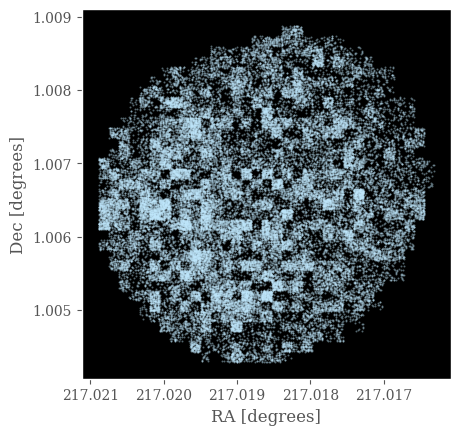

In [534]:
from matplotlib.ticker import FormatStrFormatter
catalogue = pd.read_csv("galaxy1_v3.txt", sep="\s", names=column_names, engine="python")

fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.scatter(catalogue["x"], catalogue["y"], s=1, alpha=0.3, c="#c2eaff")
# ax.scatter(ras, decs)
plt.grid()
ax.invert_xaxis()
ax.set_aspect('equal')
plt.xlabel("RA [degrees]")
plt.ylabel("Dec [degrees]")

# plt.xlim([217.021, 217.0162])
# plt.ylim([-16, -17])

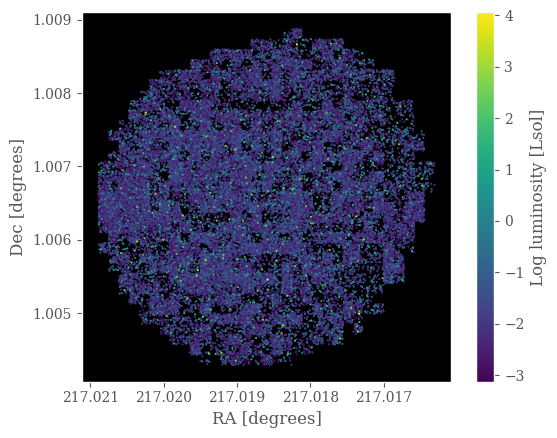

In [552]:
catalogue = pd.read_csv("galaxy1_fix.txt", sep="\s", names=column_names, engine="python")
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# last_gyr = [float(10**x)/1e9 <= 1 for x in catalogue["logt"]]

im = ax.scatter(catalogue["x"], catalogue["y"], s=1, alpha=1, c=catalogue["logL"])
ax.invert_xaxis()
ax.set_aspect('equal')
plt.xlabel("RA [degrees]")
plt.ylabel("Dec [degrees]")
cbar = fig.colorbar(im)
cbar.set_label("Log luminosity [Lsol]")
plt.grid()

In [241]:
print(np.sum(catalogue["m"])*1e6)

16374424299.999998


In [306]:
# gal2
print(np.sum(catalogue["m"])*1e6)

5782662600.0


In [47]:
10**(10.19)

15488166189.124796

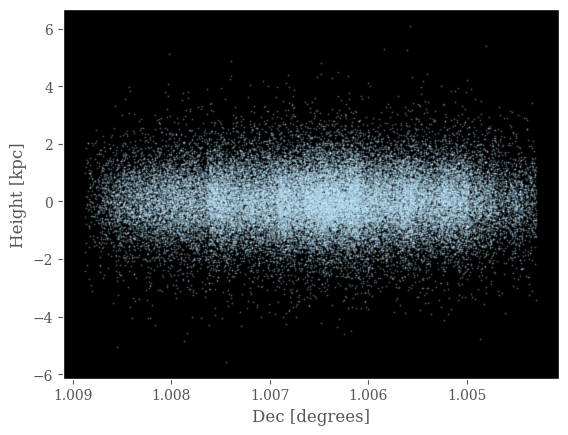

In [535]:
catalogue = pd.read_csv("galaxy1_v3.txt", sep="\s", names=column_names, engine="python")
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# last_gyr = [float(10**x)/1e9 <= 1 for x in catalogue["logt"]]

im = ax.scatter(catalogue["y"], catalogue["z"]*266.185/1000, s=1, alpha=0.2, color="#c2eaff")#, c=catalogue["Fe/H"])
ax.invert_xaxis()
# ax.set_aspect('equal')
plt.xlabel("Dec [degrees]")
plt.ylabel("Height [kpc]")
# fig.colorbar(im)
plt.grid()

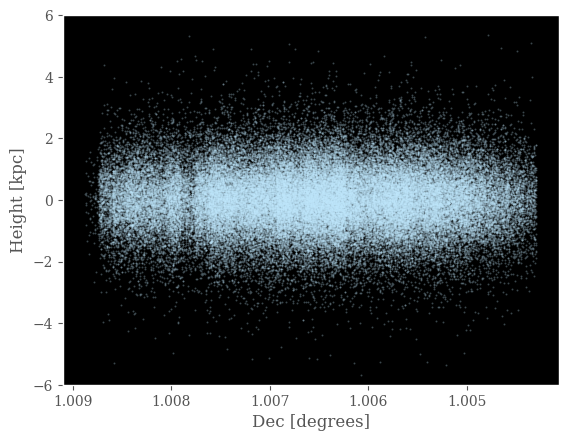

In [558]:
catalogue = pd.read_csv("galaxy1_powerIMF.txt", sep="\s", names=column_names, engine="python")
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# last_gyr = [float(10**x)/1e9 <= 1 for x in catalogue["logt"]]

im = ax.scatter(catalogue["y"], catalogue["z"]*266.185/1000, s=1, alpha=0.2, color="#c2eaff")#, c=catalogue["Fe/H"])
ax.invert_xaxis()
# ax.set_aspect('equal')
plt.xlabel("Dec [degrees]")
plt.ylabel("Height [kpc]")
plt.ylim([-6,6])
# fig.colorbar(im)
plt.grid()

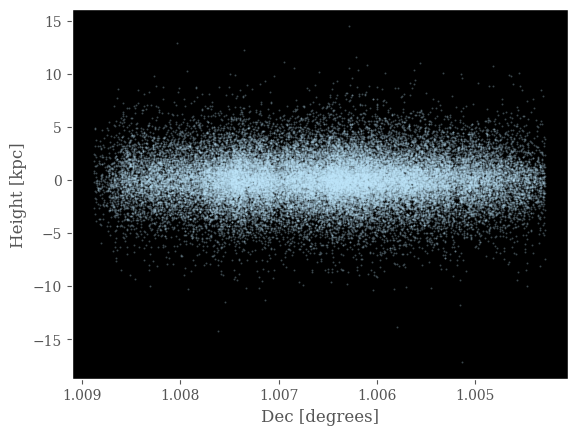

In [559]:
catalogue = pd.read_csv("galaxy1_2discs.txt", sep="\s", names=column_names, engine="python")
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# last_gyr = [float(10**x)/1e9 <= 1 for x in catalogue["logt"]]

im = ax.scatter(catalogue["y"], catalogue["z"]*266.185/1000, s=1, alpha=0.2, color="#c2eaff")#, c=catalogue["Fe/H"])
ax.invert_xaxis()
# ax.set_aspect('equal')
plt.xlabel("Dec [degrees]")
plt.ylabel("Height [kpc]")
# fig.colorbar(im)
plt.grid()

<a id='Step 6b'></a>
# Step 6b: pick a location and direction
This part still under construction - for future projects

In [ ]:
# first, need to determine which spaxels are within the line of sight

# find the coordinates of radius of FOV at dest
# needs to be perpendicular to line between obs and dest


with open("flux_per_spaxel.txt", "r") as f:
    for line in f:
        row, col, bin_no, flux = line.split()
        if np.abs(25 - int(row)) <= pixel_eff_r and np.abs(25 - int(col)) <= pixel_eff_r:
            flux_in += float(flux)
        else:
            flux_out += float(flux)

# then populate those spaxels


# finally filter by apparent magnitude

<a id='Misc'></a>
# Misc: testing, plotting, data exploration

## Extra - how symmetric?

In [351]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

# generate a list 

# ims is a list of lists, each row is a list of artists to draw in the current frame
ims = []
for i in range(36):
    im = []
    im.append(ax.imshow(flux[i*100], interpolation='none', cmap=cm, animated=True))
    im.append(ax.text(5, 5, str(i*100), fontsize=12, color="red"))
    im.append(ax.scatter(25, 25, marker="x", c="red"))
    
    ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=1, blit=True,
                                repeat_delay=1000)

ani.save("movie.gif", fps=2)

(array([27]), array([26]))

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues_r"))
  after removing the cwd from sys.path.
MovieWriter ffmpeg unavailable; using Pillow instead.
/home/sam/.local/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sam/.local/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/sam/.local/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


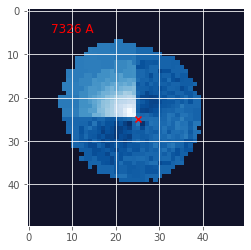

In [441]:
import matplotlib.animation as animation
fig, ax = plt.subplots()
cm = plt.get_cmap("Blues_r")
cm.set_bad(color="#111329")

snapshots = []
for i in range(36):
    this_snapshot = []
    img = np.copy(binned_flux_adaptive[i*100,:,:])
    for y in range(2):
        for x in range(2):
            if y == 0 and x == 0: pass
            else:
                j = -1 if y==1 else 1
                k = -1 if x==1 else 1
                    
                ref = img[0:25, 0:25]
                temp = np.zeros((50,50))
                temp[y*25:(y+1)*25, x*25:(x+1)*25] = ref[::j, ::k]
                img -= temp
                
    this_snapshot.append(ax.imshow(img, interpolation='none', cmap=cm, animated=True))
    this_snapshot.append(ax.text(5, 5, str(int(wavelengths[i*100])) + " A", fontsize=12, color="red"))
    this_snapshot.append(ax.scatter(25, 25, marker="x", c="red"))
    snapshots.append(this_snapshot)
    
ani = animation.ArtistAnimation(fig, snapshots, interval=1, blit=True, repeat_delay=5000)
ani.save("symmetry.gif", fps=1)

In [9]:
col_names = ["star-no", "logt", "Fe/H", "m", "logL", "logTeff", "initm", "index", "logP", "u", "g", "r", "i", "z"]
data = pd.read_csv("CMD-data/run1/P00_-0.25.txt", sep="\s+", comment="#", header=None, names=col_names, engine='python')
data = data.drop(["star-no", "initm", "index", "logP", "u", "r", "i", "z"], axis="columns")
data.to_csv("size_test.txt", index=False)

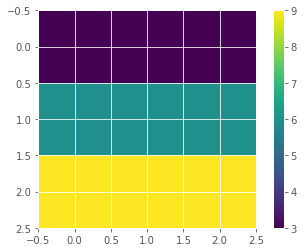

In [127]:
test = np.array([ [[1,1,1], [2,2,2], [3,3,3]],
                  [[1,1,1], [2,2,2], [3,3,3]],
                  [[1,1,1], [2,2,2], [3,3,3]],])
plt.imshow(np.sum(test,axis=0))
plt.colorbar()

## Reddening?

In [204]:
# get the header so we can grab the wavelength details
results = get_pkg_data_filename('data/106717_SPV/results_no_regul/106717/voronoi/106717_results_LW.fits')
# metal = fits.getdata(results, ext=3)
# logage = fits.getdata(results, ext=1)
fits.info(results)
results_file = fits.open(results)
results_file[0].header
# results_file.close()

Filename: data/106717_SPV/results_no_regul/106717/voronoi/106717_results_LW.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LOGAGE        1 ImageHDU         9   (50, 50)   float64   
  2  METALLICITY    1 ImageHDU         9   (50, 50)   float64   
  3  ALPHA/FE      1 ImageHDU         9   (50, 50)   float64   
  4  LASTGYRFRACTION    1 ImageHDU         9   (50, 50)   float64   
  5  GAS_REDDENING    1 ImageHDU         8   (50, 50)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

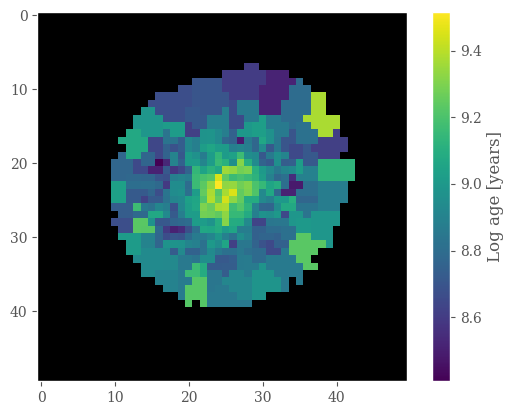

In [553]:
data = np.flip(fits.getdata(results, ext=1), 1)
plt.imshow(data)
cbar = plt.colorbar()
cbar.set_label("Log age [years]")
plt.grid()

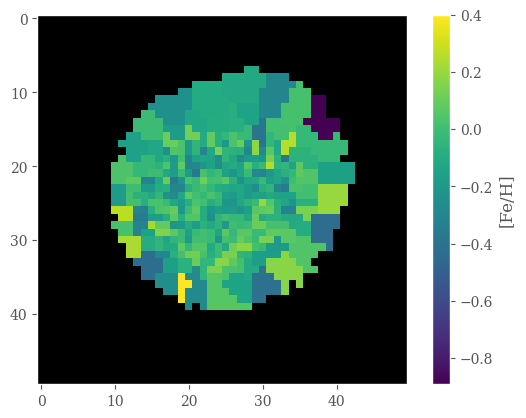

In [554]:
data = np.flip(fits.getdata(results, ext=2), 1)
plt.imshow(data)
cbar = plt.colorbar()
cbar.set_label("[Fe/H]")
plt.grid()

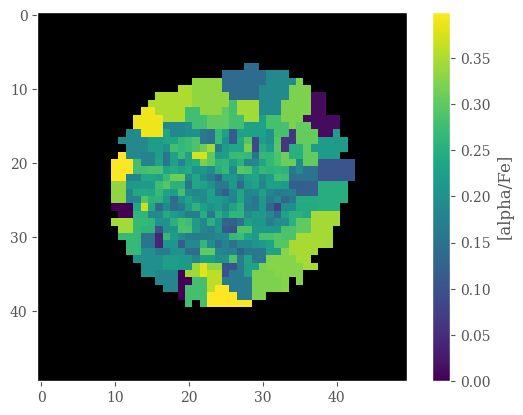

In [555]:
data = np.flip(fits.getdata(results, ext=3), 1)
plt.imshow(data)
cbar = plt.colorbar()
cbar.set_label("[alpha/Fe]")
plt.grid()

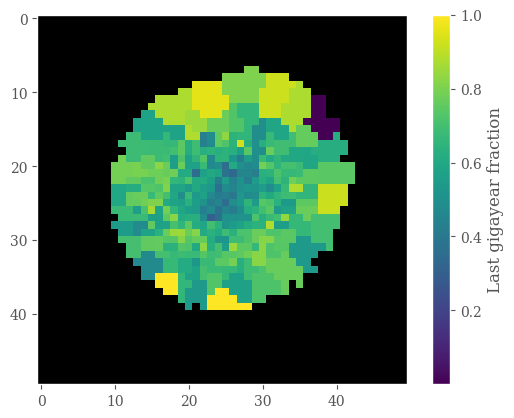

In [556]:
data = np.flip(fits.getdata(results, ext=4), 1)
plt.imshow(data)
cbar = plt.colorbar()
cbar.set_label("Last gigayear fraction")
plt.grid()

In [151]:
metal[25,25]

0.22131118383929538

In [70]:
np.where(mask==1)

(array([27]), array([26]))

In [93]:
binned_flux_adaptive.shape

(3630, 50, 50)

In [37]:
# get the header so we can grab the wavelength details
results = get_pkg_data_filename('spSpec-51690-0306-328.fit')
# metal = fits.getdata(results, ext=3)
# logage = fits.getdata(results, ext=1)
fits.info(results)
results_file = fits.open(results)
results_file[6].header
# results_file.close()

Filename: spSpec-51690-0306-328.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     244   (3869, 5)   float32   
  1                1 BinTableHDU     54   14R x 23C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1E, 1E, 1E, 1A]   
  2                1 BinTableHDU     54   44R x 23C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1E, 1E, 1E, 1A]   
  3                1 BinTableHDU     18   1R x 5C   [1E, 1E, 1E, 1J, 1E]   
  4                1 BinTableHDU     32   53R x 12C   [1J, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  5                1 BinTableHDU     26   36R x 9C   [19A, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  6                1 BinTableHDU     14   3869R x 3C   [1J, 1J, 1E]   


XTENSION= 'BINTABLE'                                                            
BITPIX  =                    8                                                  
NAXIS   =                    2                                                  
NAXIS1  =                   12                                                  
NAXIS2  =                 3869                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                    3                                                  
TFORM1  = '1J      '                                                            
TTYPE1  = 'andMask '                                                            
TFORM2  = '1J      '                                                            
TTYPE2  = 'orMask  '                                                            
TFORM3  = '1E      '        

In [22]:
data = fits.getdata(results, ext=0)

In [24]:
data.shape

(5, 3858)

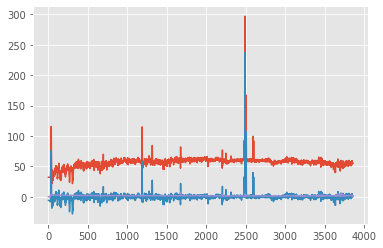

In [28]:
for i in range(3):
    plt.plot(data[i,:])

In [36]:
plt.plot(data[5,:])

IndexError: index 5 is out of bounds for axis 0 with size 5

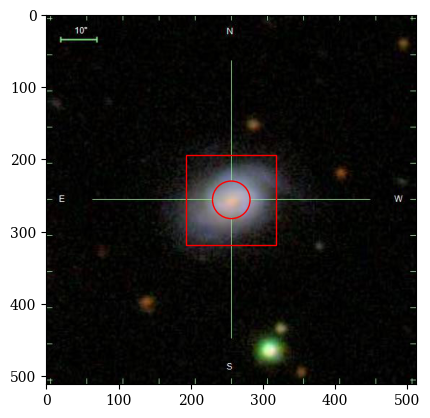

In [271]:
img = plt.imread("sdss-106717.jfif")

circle = plt.Circle((256, 256), 26, color='r', fill=False)

h = 125
rect = plt.Rectangle((256-h/2, 256-h/2), h, h, color='r', fill=False)

fig, ax = plt.subplots()

ax.add_patch(circle)
ax.add_patch(rect)
ax.imshow(img)

In [114]:
width = 0.0001388888888*50 # deg
w_arcsec = width*3600 # arcsec
px = w_arcsec * (1/0.2)
print(px)

124.99999992


In [120]:
r = 0.0001388888888*15 # deg
print(r)
r_arcsec = r*3600 # arcsec
px = r_arcsec * (1/0.2)
print(px)

0.002083333332
37.499999976000005


In [562]:
px = 15 * (1/0.2)
print(px)

75.0


In [323]:
# px to arcsec
px = 17
print(px /0.2)

85.0


In [ ]:
# 10" = 50px
# 0.2" = 1px
# r_e = 5.23" = 26px
# 22" = 

In [122]:
109.809*1000*3.636102605985395e-5

3.992767910606502

In [106]:
299792*0.02564/70

109.80952685714286

In [102]:
np.sqrt(1-((0.266**2) / (0.38**2)))

0.714142842854285

In [104]:
np.log10(0.38/0.266)

0.15490195998574316

# Plots

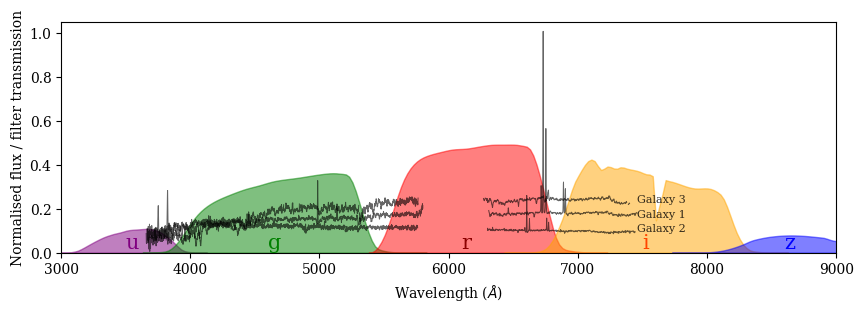

In [563]:
gal1 = get_pkg_data_filename('sv-files/106717_blue_red_11_Y14SAR3_P004_15T079_2014_04_24-2014_05_04.fits')
gal2 = get_pkg_data_filename('sv-files/240108_blue_red_7_Y15SAR4_P004_15T113_2016_03_03-2016_03_13.fits')
gal3 = get_pkg_data_filename('sv-files/9403800352_blue_red_7_Y13SBR2_P005_A4038T003_2013_10_02-2013_10_08.fits')
# binned_flux_adaptive = fits.getdata(gal3, ext=18)

plt.style.use("default")
plt.rc('font', family='serif')

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

lib = pyphot.get_library()
u = lib['SDSS_u']
g = lib['SDSS_g']
r = lib['SDSS_r']
i = lib['SDSS_i']
z = lib['SDSS_z']

plt.plot(u.wavelength.value, u.transmit, c="purple", alpha=0.0)
plt.fill_between(u.wavelength.value, u.transmit, color="purple", alpha=0.5)

plt.plot(g.wavelength.value, g.transmit, c="green", alpha=0.0)
plt.fill_between(g.wavelength.value, g.transmit, color="green", alpha=0.5)

plt.plot(r.wavelength.value, r.transmit, c="red", alpha=0.0)
plt.fill_between(r.wavelength.value, r.transmit, color="red", alpha=0.5)

plt.plot(i.wavelength.value, i.transmit, c="orange", alpha=0.0)
plt.fill_between(i.wavelength.value, i.transmit, color="orange", alpha=0.5)

plt.plot(z.wavelength.value, z.transmit, c="blue", alpha=0.0)
plt.fill_between(z.wavelength.value, z.transmit, color="blue", alpha=0.5)

plt.plot(wavelengths, fits.getdata(gal1, ext=18)[:,25,25], c="black", label="1", linewidth=0.7, alpha=0.6)
plt.plot(wavelengths, fits.getdata(gal2, ext=18)[:,25,25], c="black", label="2", linewidth=0.7, alpha=0.6)
plt.plot(wavelengths, fits.getdata(gal3, ext=18)[:,22,22], c="black", label="3", linewidth=0.7, alpha=0.6)

plt.text(7455, 0.1, "Galaxy 2", size=8, color="black", alpha=0.8)
plt.text(7455, 0.16, "Galaxy 1", size=8, color="black", alpha=0.8)
plt.text(7455, 0.23, "Galaxy 3", size=8, color="black", alpha=0.8)

plt.xlim([3000,9000])
plt.ylim([0,1.05])

plt.text(3500, 0.02, "u", size=15, color="purple")
plt.text(4600, 0.02, "g", size=15, color="green")
plt.text(6100, 0.02, "r", size=15, color="darkred")
plt.text(7500, 0.02, "i", size=15, color="orangered")
plt.text(8600, 0.02, "z", size=15, color="blue")

ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Normalised flux / filter transmission")

# plt.legend(frameon=False, handlelength=5)

plt.savefig("ugriz.png", bbox_inches="tight")

In [ ]:
cm = plt.get_cmap("Blues_r")
cm.set_bad(color="#111329")

from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

(ax1, ax2, ax3) = ImageGrid(fig, 111,
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

im = ax1.imshow(np.nanmedian(fits.getdata(gal1, ext=18), axis=0), cmap=cm, interpolation="none")
im = ax2.imshow(np.nanmedian(fits.getdata(gal2, ext=18), axis=0), cmap=cm, interpolation="none")
im = ax3.imshow(np.nanmedian(fits.getdata(gal3, ext=18), axis=0), cmap=cm, interpolation="none")

# Colorbar
cbar = ax3.cax.colorbar(im)
ax3.cax.toggle_label(True)

cbar.ax.get_yaxis().set_ticks([0.1, 0.2, 0.3])
cbar.ax.get_yaxis().set_ticks([0.05, 0.15, 0.25, 0.35], minor=True)
cbar.ax.set_ylabel("Flux ($10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)", size=10)

ax1.grid(linestyle=":")
ax1.text(3, 5, "(a)", color="white", size=15)

ax2.grid(linestyle=":")
ax2.text(3, 5, "(b)", color="white", size=15)

ax3.grid(linestyle=":")
ax3.text(3, 5, "(c)", color="white", size=15)

plt.tight_layout()

plt.savefig("flux_maps.png", bbox_inches="tight")
plt.show()

In [8]:
# writing my own distribution function
def vert_dist(z, N, z0):
    return ( 1/np.cosh(N*z/z0) )**(2/N)

4.061035490949233


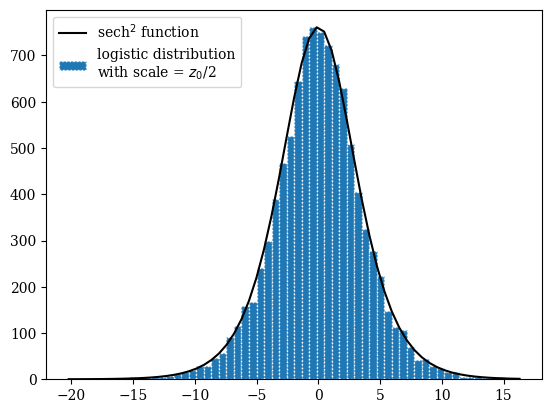

In [297]:
plt.style.use("default")
plt.rc('font', family='serif')

z0_pc = 1080.99
z0_px = z0_pc / (2.424068405541685893e-6 * (0.02564*299792/70)*1e6)

print(z0_px)

loc, scale = 0, z0_px/2
s = np.random.logistic(loc, scale, 10000)# + np.random.logistic(loc, scale+1, 10000)
count, bins, ignored = plt.hist(s, bins=60, edgecolor="white", linestyle=':', label="logistic distribution\nwith scale = $z_0$/2")

lgst_val = vert_dist(bins, 1, z0_px)
plt.plot(bins, lgst_val * count.max() / lgst_val.max(), color="black", label="sech$^2$ function")
plt.legend(loc="upper left")
plt.show()

# s = z0/2.5

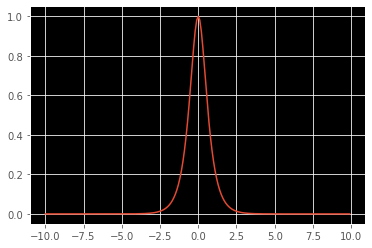

In [149]:
z0, N = 1, 2
z = np.arange(-10, 10, 0.1)
plt.plot(z, ( 1/np.cosh(N*z/z0) )**(2/2))

In [ ]:
sig_0 = 2 * z_0 * L_0
def sig(r):
    return sig_0 * np.exp(r/h_r)

In [12]:
# find scale length myself

# grab stuff
open_file = fits.open(gal1)
cdelt = open_file[0].header["CDELT2"]
open_file.close()

brightnesses = np.zeros(30)

with open("flux_per_spaxel.txt", "r") as f:
    for line in f:
        row, col, bin_no, flux = line.split()
        dist = np.sqrt(np.abs(25 - int(row))**2 + np.abs(25 - int(col))**2)
        
        # bins :
        #    [0-1) : 0
        #    [1-2) : 1
        #    [2-3) : 2
        #    ...
        brightnesses[int(np.floor(dist))] += float(flux)
        
central = brightnesses[0] + brightnesses[1]

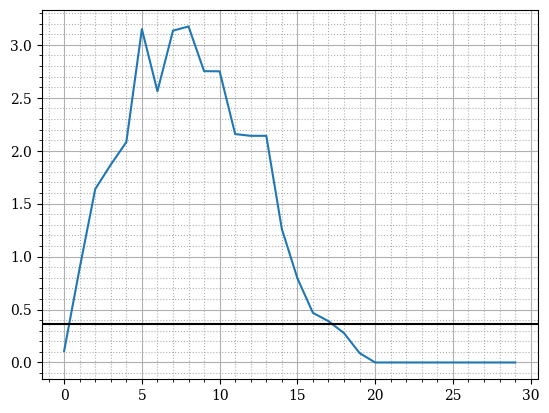

In [13]:
x = np.arange(0,29,1)

ratios = [b/central for b in brightnesses]

plt.plot(ratios)
plt.minorticks_on()
plt.grid(which='minor', linestyle=":")
plt.grid(which='major')
plt.axhline(1/np.e, color="black")

In [ ]:

    # clumpy version
#     density_map = np.zeros((50,50,50))
#     for star in star_list:

#         # ----------
#         temp_x = np.random.uniform(spx_col-0.5, spx_col+0.5)
#         temp_y = np.random.uniform(spx_row-0.5, spx_row+0.5)
        
#         orig_z = np.random.logistic(scale=1, size=1)[0]
#         temp_z = orig_z + 25
        
#         coord_x, coord_y, coord_z = int(np.floor(temp_x)), int(np.floor(temp_y)), int(np.floor(temp_z))

#         if np.max(density_map) != 0:

#             # find highest density pixel in range 10
#             highest, found = 0, False
#             for row in range(coord_y-10, coord_y+10):
#                 for col in range(coord_x-10, coord_x+10):
#                     for h in range(coord_z-10, coord_z+10):
#                         if row >= 0 and row <= 49 and col >= 0 and col <= 49:
#                             if density_map[row, col, h] >= highest and dist((row, col, h), (temp_y, temp_x, temp_z)) <= 10:
#                                 highest = density_map[row, col, h]
#                                 found = (row, col, h)

#             if found:
#                 perc = np.random.uniform(0, 1)
#                 temp_y = temp_y + perc*(found[0]-temp_y)
#                 temp_x = temp_x + perc*(found[1]-temp_x)
#                 orig_z = orig_z + perc*(found[2]-temp_z)
#                 temp_z = temp_z + perc*(found[2]-temp_z)

#                 coord_x, coord_y, coord_z = int(np.floor(temp_x)), int(np.floor(temp_y)), int(np.floor(temp_z))

#         # add density around star coords
#         for row in range(coord_y-10, coord_y+10):
#             for col in range(coord_x-10, coord_x+10):
#                 for h in range(coord_z-10, coord_z+10):
#                     if row >= 0 and row <= 99 and col >= 0 and col <= 99:
#                         if dist((row, col, h), (temp_y, temp_x, temp_z)) <= 1: density_map[row, col, h] += 9
#                         elif dist((row, col, h), (temp_y, temp_x, temp_z)) <= 3: density_map[row, col, h] += 3
#                         elif dist((row, col, h), (temp_y, temp_x, temp_z)) <= 10: density_map[row, col, h] += 1
                            
#         new_list.append(f"{star} {temp_y} {temp_x} {orig_z}")
        # ----------
        

In [30]:
gal1 = get_pkg_data_filename('sv-files/106717_blue_red_11_Y14SAR3_P004_15T079_2014_04_24-2014_05_04.fits')
binned_flux_adaptive = fits.getdata(gal1, ext=18)
shape = binned_flux_adaptive.shape

mask = fits.getdata(gal1, ext=17)

In [31]:
# get the header so we can grab the wavelength details
open_file = fits.open(gal1)
naxis, crpix, cdelt, crval, slice_size = open_file[0].header["NAXIS3"], open_file[0].header["CRPIX3"], \
                                         open_file[0].header["CDELT3"], open_file[0].header["CRVAL3"], \
                                         open_file[0].header["NAXIS1"]
open_file.close()

# make array of wavelengths
min_wav = crval-(crpix-1)*cdelt
max_wav = crval + (naxis-crpix)*cdelt
wavelengths = np.linspace(min_wav, max_wav, naxis)

# prepare data to use with the pyphot filter
blue_cube = binned_flux_adaptive[100:1850,:,:]*(10**(-16)) # selected blue cube to get rid of pesky NANs
fluxes = []
for bin_number in range(1, len(np.unique(mask))): # skip bin zero since it denotes the NANs
    
    # each bin has identical spectra, so we only want to grab one spectrum from each bin
    # we'll get the first spectrum from each bin that has no NANs in it
    # sometimes there are random NANs in the middle idk why
    locs = np.where(mask == bin_number)
    number_spaxels_in_bin = locs[0].shape[0]
    found = False
    
    for spx in range(number_spaxels_in_bin):
        if np.count_nonzero(np.isnan(blue_cube[:, locs[0][spx], locs[1][spx]])) == 0:
            fluxes.append(blue_cube[:, locs[0][spx], locs[1][spx]])
            found = True
            break
            
    # if no other spectra to use, fill in the NANs with the mean of neighbouring values
    if not found:
        row = locs[0][0]
        col = locs[1][0]
        for nan in np.where(np.isnan(blue_cube[:, row, col]) == True)[0]:
        
            # find next lowest value that isn't a NAN
            curr = blue_cube[nan, row, col]
            x = nan
            while(np.isnan(curr)):
                curr = blue_cube[x, row, col]
                x -= 1
            low = x + 1

            # find next highest value that isn't a NAN
            curr = blue_cube[nan, row, col]
            x = nan
            while(np.isnan(curr)):
                curr = blue_cube[x, row, col]
                x += 1
            high = x - 1

            blue_cube[nan, row, col] = np.mean([blue_cube[low, row, col], blue_cube[high, row, col]])
        fluxes.append(blue_cube[:, row, col])

# turn into an array to pass into the SEDs function
fluxes_array = np.array(fluxes)

# using SDSS g-band filter, need to use reinterp to get the wavelength range to match
# extractSEDs used instead of getFlux since it is faster when applying to many spectra
lib = pyphot.get_library()
f = lib['GROUND_JOHNSON_B'].reinterp(wavelengths[100:1850]*pyphot.unit['angstrom'])

cls, seds = pyphot.extractSEDs(wavelengths[100:1850], fluxes_array, [f], absFlux=False)

Photometry:|##########| 1/1 100% [time: 00:00, eta: 00:00, 11.09 iters/sec]    


In [34]:
# output to a text file like so:
# spaxel row | spaxel column | belongs to bin # | total flux

spaxels = np.array(np.where(mask != 0))
spaxel_belongs_to_bin = np.array([mask[r][c] for r,c in spaxels.T])
flux_per_spaxel = np.array([seds[int(bin_no - 1)] for bin_no in spaxel_belongs_to_bin])

stacked = np.vstack((spaxels, spaxel_belongs_to_bin.T, flux_per_spaxel.T))

out = open("B-band-flux.txt", "w")
np.savetxt(out, stacked.T, delimiter=' ', fmt=['%d', '%d', '%d', '%.8e'])
out.close()

In [35]:
total_B_band_flux = 0

with open("B-band-flux.txt", "r") as b_band:
    for line in b_band:
        row, col, bin_no, flux = line.split()
        flux = float(flux)
        total_B_band_flux += flux

In [36]:
total_B_band_flux

4.600780670609991e-15

In [40]:
d = (0.02564*299792)/70 # Mpc
m = -2.5 * np.log10(total_B_band_flux / 5.8959017729377395e-09)
M = m + 5 - 5*np.log10(d * 1e6)

print(M)

-19.933903327673214


In [41]:
m

15.269296773716952

/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues_r"))
  if __name__ == '__main__':


Text(2, 47, '$\\lambda = 4500 \\AA$')

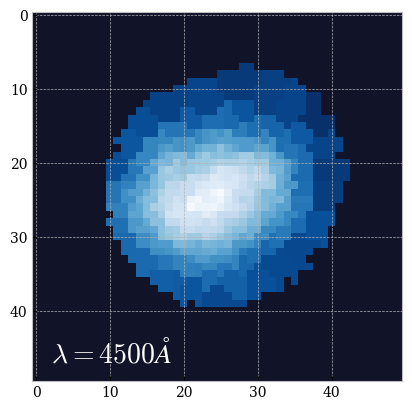

In [222]:
gal3 = get_pkg_data_filename('sv-files/9403800352_blue_red_7_Y13SBR2_P005_A4038T003_2013_10_02-2013_10_08.fits')
flux = fits.getdata(gal1, ext=18)

flux = np.flip(flux, 2)


plt.style.use("bmh")
cm = plt.get_cmap("Blues_r")
cm.set_bad(color="#111329")
plt.imshow(flux[800,:,:], interpolation='none', cmap=cm)
# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().axes.xaxis.set_ticklabels([])
plt.text(2, 47, "$\lambda = 4500 \AA$", color="white", fontsize=20)

In [66]:
incl = 50 # deg
for row in range(50):
    for col in range(50):
       

In [62]:
flux[2].shape

(50, 50)

In [116]:
pos = (30, 30)
vector_1 = [0, 1]
vector_2 = [(50-pos[0])-25, (50-pos[1])-25]

unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

In [117]:
angle*(180/np.pi)

135.0